In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
def writeToFile(dataset_test, test, clf, clf_name):
  res = pd.DataFrame(clf.predict(dataset_test))
  res.columns=['Survived']
  res = pd.concat([test.PassengerId,res], axis=1).set_index('PassengerId')
  res.to_csv('titanic_submission_'+clf_name+'.csv')

In [ ]:
def getCabinCat(cabin_code):
    if pd.isnull(cabin_code):
        cat = 'None' # Use a string so that it is clear that this is 
                     # a category on its own
    else:
        cat = cabin_code[0]
    return cat

In [ ]:
def preprocessing (dataset):
    ''' 
      собрал все обработки в одку функцию для красоты 
    '''

    med_fare = dataset.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
    # Filling the missing value in Fare with the median Fare of 3rd class alone passenger
    dataset['Fare'] = dataset['Fare'].fillna(med_fare)

    # dataset['Family'] = dataset.SibSp + dataset.Parch
    # dataset.drop(columns=['SibSp','Parch'],inplace=True)


    cabin_cats = np.array([getCabinCat(cc) for cc in dataset['Cabin'].values])
    dataset = dataset.assign(Cabin_cat=cabin_cats)
    dataset = dataset.drop('Cabin', axis=1)
    dataset = dataset.drop('Ticket', axis=1)
    dataset.Age = dataset.Age.fillna(dataset.groupby('Title')['Age'].transform('median'))
    le = LabelEncoder()

    dataset['Sex'] = le.fit_transform(dataset['Sex'])
    dataset['Embarked'] = le.fit_transform(dataset.Embarked.fillna(dataset.Embarked.value_counts().idxmax()).astype(str))
    dataset['Cabin_cat'] = le.fit_transform(dataset.Cabin_cat.fillna(dataset.Cabin_cat.value_counts().idxmax()).astype(str))

    return dataset

In [ ]:
def preprocessing_title (dataset):
    ''' 
      собрал все обработки в одку функцию для красоты 
    '''
    patt = re.compile('\s(\S+\.)') # 1 whitespace character followed by several 
    # non-whitespace characters followed by a dot

    titles = np.array([re.search(patt, i)[1] for i in dataset['Name'].values])

    dataset = dataset.assign(Title=titles)
    dataset.drop('Name', axis=1,inplace=True)

    dataset['Title'] = dataset['Title'].replace('Mlle.','Miss.')
    dataset['Title'] = dataset['Title'].replace('Master.','Master.')
    dataset['Title'] = dataset['Title'].replace('Ms.','Miss.')  
    dataset['Title'] = dataset['Title'].replace('Mme.','Mrs.')
    dataset['Title'] = dataset['Title'].replace(['Capt.','Col.','Major.'],'Army.')
    dataset['Title'] = dataset['Title'].replace(['Countess.','Don.','Jonkheer.','Lady.','Sir.'],'Noble.')
    le = LabelEncoder()
    dataset['Title'] = le.fit_transform(dataset['Title'])
    return dataset

In [ ]:
def preprocessing_ticket (dataset):
    ticket_names = ['A5A4','СA','FC','PC','ST']
    dataset['Ticket'].mask(dataset['Ticket'].str.contains('A/5'),'A5A4',inplace=True)
    dataset['Ticket'].mask(dataset['Ticket'].str.contains('A/4'),'A5A4',inplace=True)
    dataset['Ticket'].mask(dataset['Ticket'].str.contains('A.5/'),'A5A4',inplace=True)
    dataset['Ticket'].mask(dataset['Ticket'].str.contains('A./5'),'A5A4',inplace=True)
    dataset['Ticket'].mask(dataset['Ticket'].str.contains('A.5.'),'A5A4',inplace=True)
    dataset['Ticket'].mask(dataset['Ticket'].str.contains('A4'),'A5A4',inplace=True)
    dataset['Ticket'].mask(dataset['Ticket'].str.contains('C.A.'),'СA',inplace=True)
    dataset['Ticket'].mask(dataset['Ticket'].str.contains('СA'),'СA',inplace=True)
    dataset['Ticket'].mask(dataset['Ticket'].str.contains('F.C.C.'),'FC',inplace=True)
    dataset['Ticket'].mask(dataset['Ticket'].str.contains('F.C.'),'FC',inplace=True)
    dataset['Ticket'].mask(dataset['Ticket'].str.contains('PC'),'PC',inplace=True)
    dataset['Ticket'].mask(dataset['Ticket'].str.contains('STON'),'ST',inplace=True)
    dataset['Ticket'].mask(dataset['Ticket'].str.contains('SOTON'),'ST',inplace=True)

    dataset.Ticket = dataset['Ticket'].apply(lambda x: 'OTHER' if not x in ticket_names else x)
    le = LabelEncoder()
    dataset.Ticket = le.fit_transform(dataset.Ticket)    

In [ ]:
# def preproc_title_numeric(dataset):
#     check_numeric = dataset[dataset.Ticket.apply(lambda x: x.isnumeric())]
#     check_numeric['Ticket'] = check_numeric.Ticket.astype(int)

#     check_numeric.loc[(check_numeric.Ticket) < 10000,'Ticket'] = 0
#     check_numeric.loc[(check_numeric.Ticket >= 10000) & (check_numeric.Ticket < 100000),'Ticket'] = 1
#     check_numeric.loc[(check_numeric.Ticket >= 100000) & (check_numeric.Ticket < 114000),'Ticket'] = 2
#     check_numeric.loc[(check_numeric.Ticket >= 114000) & (check_numeric.Ticket < 260000),'Ticket'] = 3
#     check_numeric.loc[(check_numeric.Ticket >= 260000) & (check_numeric.Ticket < 316000),'Ticket'] = 4
#     check_numeric.loc[(check_numeric.Ticket >= 316000) & (check_numeric.Ticket < 350000),'Ticket'] = 5
#     check_numeric.loc[(check_numeric.Ticket >= 350000) & (check_numeric.Ticket < 400000),'Ticket'] = 6
#     check_numeric.loc[(check_numeric.Ticket >= 1000000) & (check_numeric.Ticket < 3200000),'Ticket'] = 7
#     check_numeric['Ticket'] = check_numeric.Ticket.astype(str)

#     for indices, row in check_numeric.iterrows():
#         # print(row.PassengerId)
#         if dataset[dataset.PassengerId == row.PassengerId].any().PassengerId:
#             dataset.loc[dataset.PassengerId == row.PassengerId,'Ticket'] = row.Ticket

#     return dataset

In [ ]:
dataset_train = pd.read_csv('/content/drive/MyDrive/datasets/train_titanic.csv')

In [ ]:
dataset_test = pd.read_csv('/content/drive/MyDrive/datasets/test_titanic.csv')

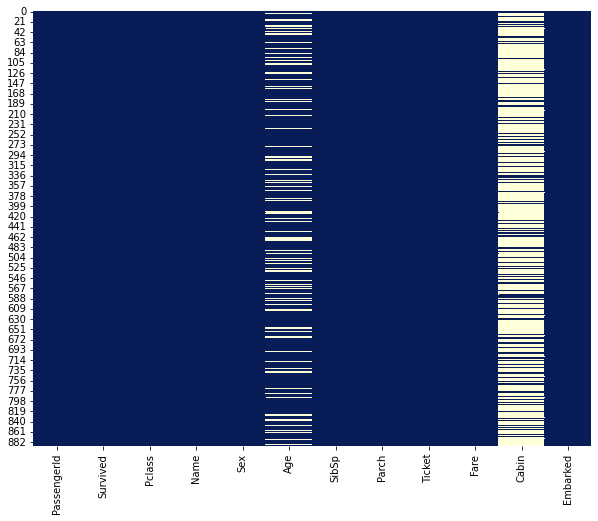

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(dataset_train.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/datasets/test_titanic.csv')
train = pd.read_csv('/content/drive/MyDrive/datasets/train_titanic.csv')

In [ ]:
dataset_train = preprocessing_title(dataset_train)
dataset_test = preprocessing_title(dataset_test)

In [ ]:
dataset_train = preprocessing(dataset_train)
dataset_test = preprocessing(dataset_test)

In [ ]:
# dataset_train_ = preprocessing_ticket(dataset_train)
# dataset_test_ = preprocessing_ticket(dataset_test)

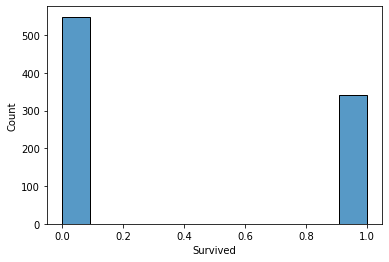

In [ ]:
sns.histplot(dataset_train.Survived)

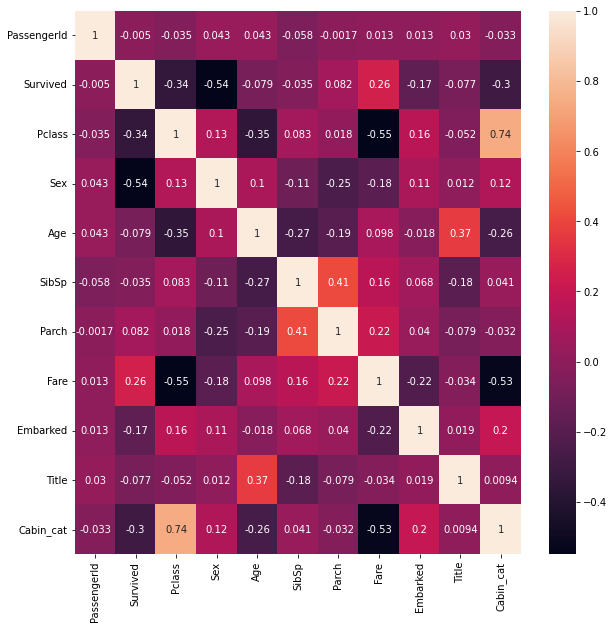

In [ ]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(dataset_train.corr(),annot=True)

In [ ]:
dataset_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_cat
0,1,0,3,1,22.0,1,0,7.2500,2,4,7
1,2,1,1,0,38.0,1,0,71.2833,0,5,2
2,3,1,3,0,26.0,0,0,7.9250,2,3,7
3,4,1,1,0,35.0,1,0,53.1000,2,5,2
4,5,0,3,1,35.0,0,0,8.0500,2,4,7


# Decision tree with GridSearch

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = dataset_train.drop(columns=['Survived'], axis=1)
y = dataset_train.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
parameters = {'max_depth':range(1,10),'min_samples_leaf':range(2,10,2),'min_samples_split':range(2,10,2)}
estimator = DecisionTreeClassifier()
clf_grid = GridSearchCV(estimator, parameters, cv=5)

In [ ]:
clf_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(2, 10, 2),
                         'min_samples_split': range(2, 10, 2)})

In [ ]:
bst = clf_grid.best_estimator_

In [ ]:
bst.score(X_train,y_train)

0.8609550561797753

In [ ]:
bst.score(X_test,y_test)

0.8212290502793296

In [ ]:
writeToFile(dataset_test, test, bst, "tree")

# Логистическая регрессия

In [ ]:
from imblearn.under_sampling import NearMiss

In [ ]:
X = dataset_train.drop(columns=['Survived'], axis=1)
y = dataset_train.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
nm = NearMiss()
X_train_miss, y_train_miss = nm.fit_resample(X_train, y_train.ravel())

In [ ]:
clf_log = LogisticRegression()

In [ ]:
parameters = {'C':[0.8,1,1.3,1.5],
              'max_iter':[1000,1500]}

In [ ]:
log_reg_srch = GridSearchCV(clf_log,parameters)

In [ ]:
clf_log.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
log_reg_srch.best_estimator_

LogisticRegression(C=1.3, max_iter=1000)

In [ ]:
log_reg_srch.score(X_train,y_train)

0.8019662921348315

In [ ]:
log_reg_srch.score(X_test,y_test)

0.8100558659217877

In [ ]:
writeToFile(dataset_test, test, log_reg_srch, "log")

# support vector machine

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf_svm = SVC()
parameters_svc = {'kernel':['rbf', 'sigmoid'],'C':range(1,10)}
srch_svc = GridSearchCV(clf_svm, parameters_svc)

In [ ]:
srch_svc.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': range(1, 10), 'kernel': ['rbf', 'sigmoid']})

In [ ]:
srch_svc.best_estimator_

SVC(C=8)

In [ ]:
srch_svc.best_estimator_.score(X_train, y_train)

0.6811797752808989

In [ ]:
srch_svc.best_estimator_.score(X_test, y_test)

0.6424581005586593

# KNN

In [ ]:
clf_knn = KNeighborsClassifier()
parameters_knn = {'n_neighbors':range(2,10)}
srch_knn = GridSearchCV(clf_knn,parameters_knn)

In [ ]:
srch_knn.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(2, 10)})

In [ ]:
srch_knn.best_estimator_

KNeighborsClassifier(n_neighbors=8)

In [ ]:
srch_knn.best_estimator_.score(X_train, y_train)

0.702247191011236

In [ ]:
srch_knn.best_estimator_.score(X_test, y_test)

0.6480446927374302

In [ ]:
writeToFile(dataset_test_, test, srch_knn.best_estimator_)

TypeError: ignored

# Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

In [ ]:
X = dataset_train.drop(columns=['Survived'], axis=1)
y = dataset_train.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = RandomForestClassifier()
parameters = {'n_estimators':[3,5,7],'max_depth':[6,8,10,20],'criterion':['gini','entropy'],'min_samples_leaf':[5,10],'min_samples_split':[5,10,20]}

In [ ]:
CV = KFold(n_splits=3, random_state=None, shuffle=True)
srch = GridSearchCV(clf,parameters,cv=CV)

In [ ]:
srch.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 8, 10, 20],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [3, 5, 7]})

In [ ]:
srch.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=5)

In [ ]:
srch.best_estimator_.score(X_train,y_train)

0.8635634028892456

In [ ]:
srch.best_estimator_.score(X_test,y_test)

0.8022388059701493

In [ ]:
writeToFile(dataset_test, test, srch.best_estimator_, "forest")

# Шкалирование данных

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
X = dataset_train.drop(columns=['Survived'], axis=1)
y = dataset_train.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
dataset_test_scalled = pd.DataFrame(scaler.transform(dataset_test))

In [ ]:
X_train.columns = dataset_train.drop(columns=['Survived'],axis=1).columns
X_test.columns = dataset_test.columns

In [ ]:
dataset_test_scalled.columns = dataset_test.columns

обучим логистическую модель на шкалированных данных

In [ ]:
clf_log = LogisticRegression(max_iter=2500)
clf_log.fit(X_train,y_train)

LogisticRegression(max_iter=2500)

In [ ]:
clf_log.score(X_train,y_train)

0.7991573033707865

In [ ]:
clf_log.score(X_test,y_test)

0.8100558659217877

In [ ]:
writeToFile(dataset_test_scalled, test, clf_log, "log_scale")

# XGBoost classifier

In [ ]:
import xgboost as xgb

In [ ]:
xgb_cl = xgb.XGBClassifier()
CV = KFold(n_splits=3, random_state=42, shuffle=True)

In [ ]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              # 'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [4, 10, 15],
              'min_child_weight': [4],
              'lambda': [0.5],
              'alpha': [0, 0.5],
              'subsample': [0.5, 0.7],
              # 'colsample_bytree': [0.3, 0.5, 0.6],
              'colsample_bytree':[0.5], 
              # 'colsample_bylevel':[0.5], 
              # 'colsample_bynode':[0.5],
              'n_estimators':[300,600,1000],
              'max_depth':[5,6,8]}

xgb_grid = GridSearchCV(xgb_cl,
                        parameters,
                        cv = CV,
                        n_jobs = 5,
                        verbose=True)

In [ ]:
xgb_grid.fit(X_train,y_train)

In [ ]:
xgb_grid.best_estimator_

In [ ]:
xgb_grid.best_estimator_.n_estimators

In [ ]:
xgb_grid.score(X_train,y_train)

In [ ]:
xgb_grid.score(X_test,y_test)

In [ ]:
writeToFile(dataset_test, test, xgb_grid, "xgboost")

# Naive Bayes

In [ ]:
from sklearn import naive_bayes

In [ ]:
model_NB = naive_bayes.BernoulliNB()

In [ ]:
model_NB.fit(X_train,y_train)

BernoulliNB()

In [ ]:
model_NB.score(X_train,y_train)

0.7865168539325843

In [ ]:
model_NB.score(X_test,y_test)

0.7821229050279329

In [ ]:
writeToFile(dataset_test, test, model_NB, "naive_bayes")

# Stacking

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn import naive_bayes
from sklearn.svm import SVC
import xgboost as xgb

In [ ]:
def get_models():
    models = dict()
    models['stacking'] = get_stacking()
    return models

In [ ]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('xgb',xgb.XGBClassifier(alpha=0, colsample_bytree=0.5, learning_rate=0.05,max_depth=6, min_child_weight=4, n_estimators=300, nthread=4,subsample=0.7)))
    level0.append(('svc',SVC(C=9)))
    level0.append(('knn',KNeighborsClassifier(n_neighbors=7)))
    level0.append(('bayes',naive_bayes.GaussianNB()))
    # define meta learner model
    level1 = LogisticRegression(C=0.8, random_state=42)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)
    return model

In [ ]:
models = get_models()

In [ ]:
models['stacking']

In [ ]:
models['stacking'].fit(X_train,y_train)

In [ ]:
models['stacking'].score(X_train,y_train)

In [ ]:
models['stacking'].score(X_test,y_test)

In [ ]:
writeToFile(dataset_test, test, models['stacking'], "stacking")

# catboost

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
cat_model = CatBoostClassifier()

In [ ]:
cat_model.fit(X_train,y_train,silent=True)

In [ ]:
cat_model.feature_importances_

In [ ]:
cat_model.score(X_train,y_train)

In [ ]:
cat_model.score(X_test,y_test)

In [ ]:
writeToFile(dataset_test, test, cat_model, "catBoost")